In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn import linear_model, preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import KFold, learning_curve, cross_val_score, train_test_split

from joblib import dump
import warnings
warnings.filterwarnings('ignore')



In [2]:
# Loading the dataset from the uploaded file
file_path = 'C:/Users/victo/OneDrive/Documents/GSU/FDS CSC 6780/project/studentper.csv'  # Update the file name accordingly
df = pd.read_csv(file_path)
# Display a sample of the data
print(df.sample(10))

    school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
171     GP   M   16       R     GT3       T     2     2  at_home     other   
87      GP   F   15       U     GT3       T     4     2    other     other   
316     GP   F   17       U     GT3       T     2     4  at_home    health   
415     GP   F   19       U     GT3       T     4     4  teacher     other   
375     GP   F   17       U     LE3       T     0     2  at_home   at_home   
275     GP   F   18       U     GT3       T     2     1    other     other   
214     GP   F   16       U     GT3       T     4     3   health     other   
409     GP   M   18       U     LE3       A     3     4    other     other   
481     MS   F   17       R     GT3       T     2     1  at_home     other   
46      GP   F   16       U     LE3       A     3     3    other  services   

     ... famrel freetime  goout  Dalc  Walc health absences  G1  G2  G3  
171  ...      4        2      2     1     2      3        4  12  10

# DATA EXPLORATION

## statistical descriptions of data before pre-processing

In [3]:
#Mean
#df.shape
stat_descriptions = df.describe()
print(stat_descriptions)

              age        Medu        Fedu  traveltime   studytime    failures  \
count  649.000000  649.000000  649.000000  649.000000  649.000000  649.000000   
mean    16.744222    2.514638    2.306626    1.568567    1.930663    0.221880   
std      1.218138    1.134552    1.099931    0.748660    0.829510    0.593235   
min     15.000000    0.000000    0.000000    1.000000    1.000000    0.000000   
25%     16.000000    2.000000    1.000000    1.000000    1.000000    0.000000   
50%     17.000000    2.000000    2.000000    1.000000    2.000000    0.000000   
75%     18.000000    4.000000    3.000000    2.000000    2.000000    0.000000   
max     22.000000    4.000000    4.000000    4.000000    4.000000    3.000000   

           famrel    freetime       goout        Dalc        Walc      health  \
count  649.000000  649.000000  649.000000  649.000000  649.000000  649.000000   
mean     3.930663    3.180277    3.184900    1.502311    2.280431    3.536210   
std      0.955717    1.0510

### Plot histogram,correlation & countplot for dataset

In [4]:
#df.info()


def plot_corr(df, annot=True):
    numeric_columns = df._get_numeric_data().columns
    _, ax = plt.subplots(figsize=(16, 12))
    sns.heatmap(
        df[numeric_columns].corr(method='pearson'),
        annot=annot,
        cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True),
        ax=ax
    )
    _.set_facecolor("whitesmoke")
    



def plot_histplot(column):
    sns.histplot(x=column, color='#65b87b', alpha=.7) 
    
    
def plot_countplot(df, column_name, ax=None):
    _df = df[[column_name]].copy()
    if len(_df[_df[column_name].isnull()]):
        _df.fillna('NaN', inplace=True)
    
    color = '#42b0f5' if ax != None else '#7661ff'
    sns.countplot(x=column_name, data=_df, color=color, alpha=.7, ax=ax)
    del _df




### Pearson Correlation between all the features after using one hot encoding to convert categorical features 

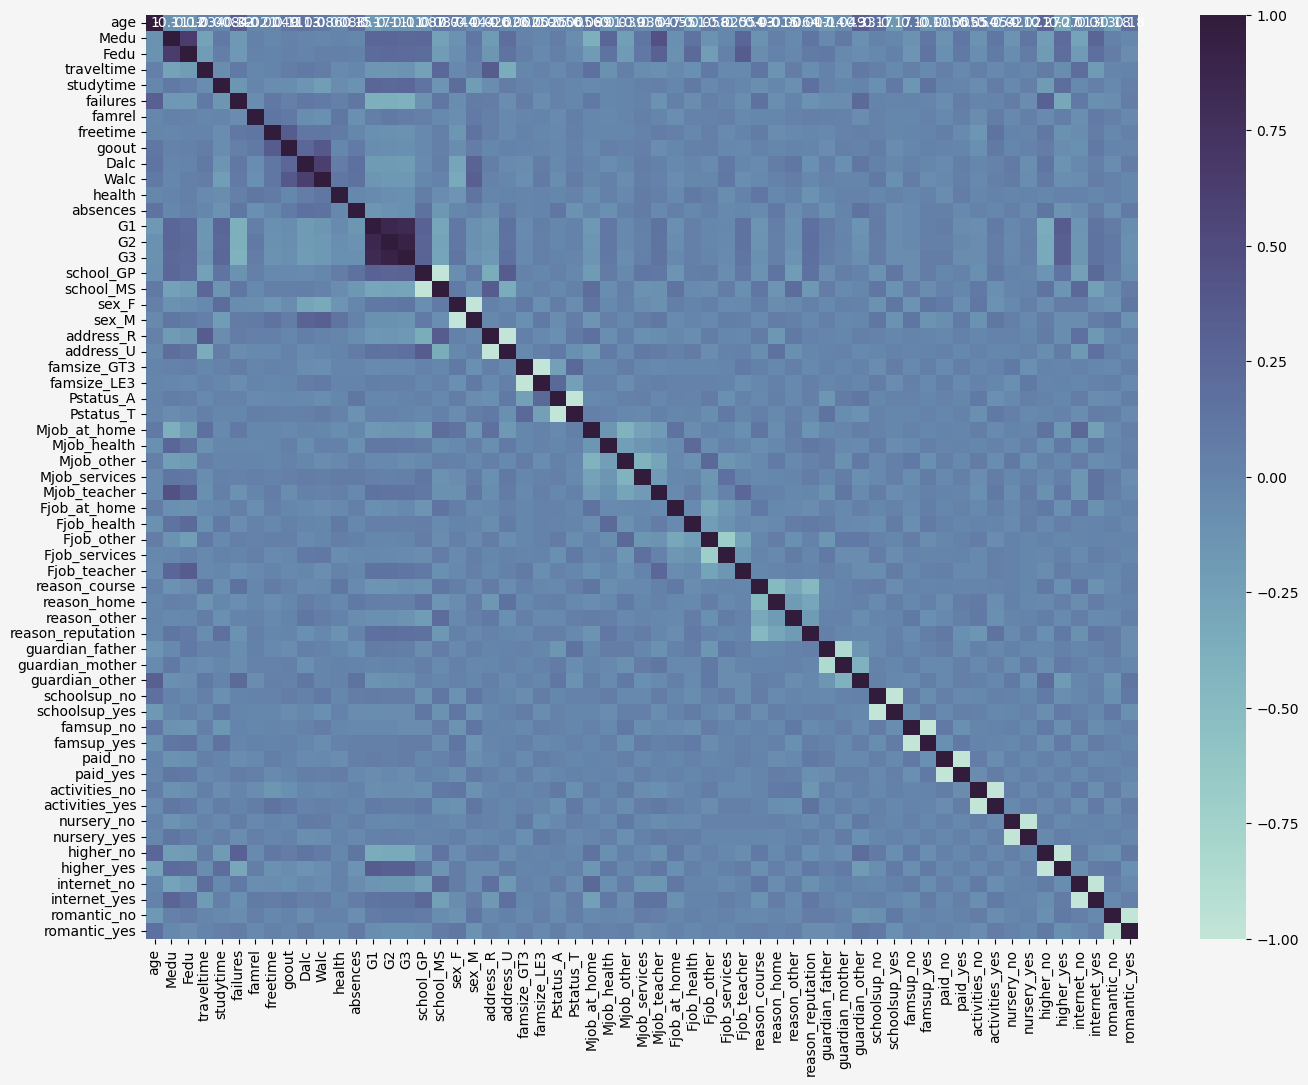

In [5]:
categorical_cols = df.select_dtypes(include='object').columns

ohe_df = pd.get_dummies(df,columns = categorical_cols)
ohe_df.head()
plot_corr(ohe_df, annot=True)

#### Histogram of the proposed target class G3 shows that the scores are skewed right which is a good  thing given that exams scores tend to be around and above average in the real-world

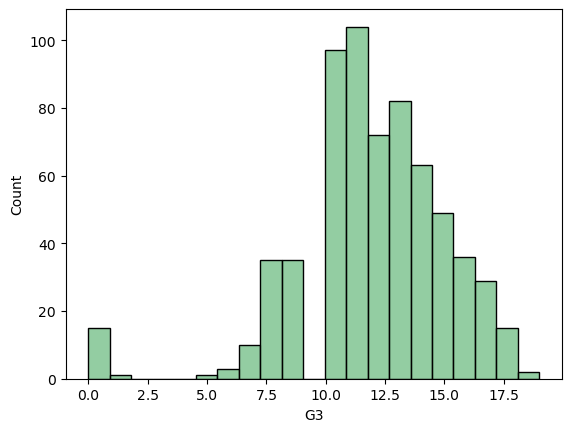

In [6]:
plot_histplot(df['G3'])

### Pearson Correlation between the numeric features to be taken into consideration for training the model

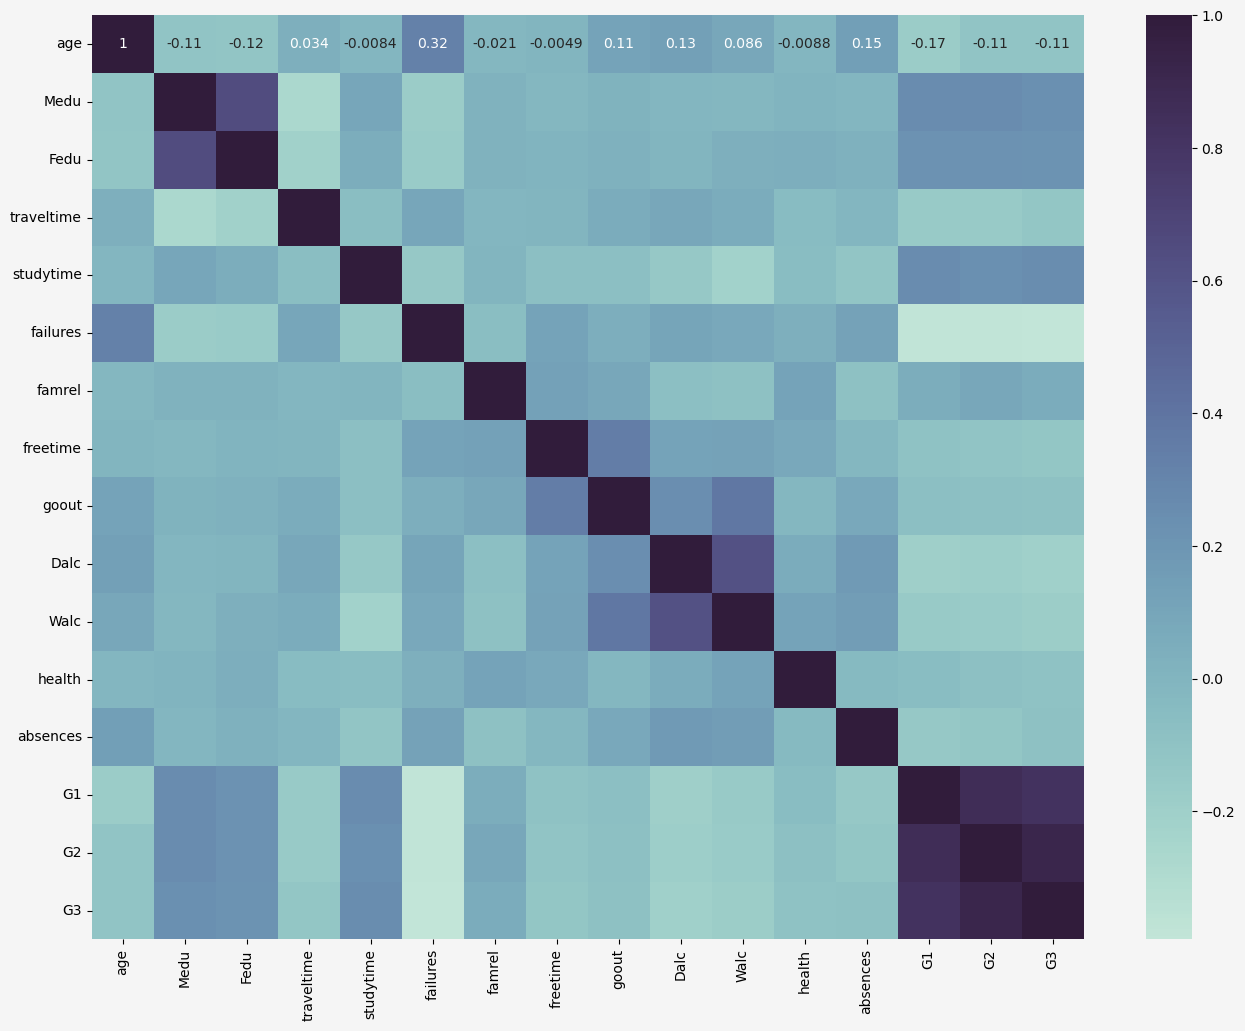

In [7]:
plot_corr(df, annot=True)
df_targets= df[['G1','G2','G3']]



### Below are charts of data exploration of categorical features

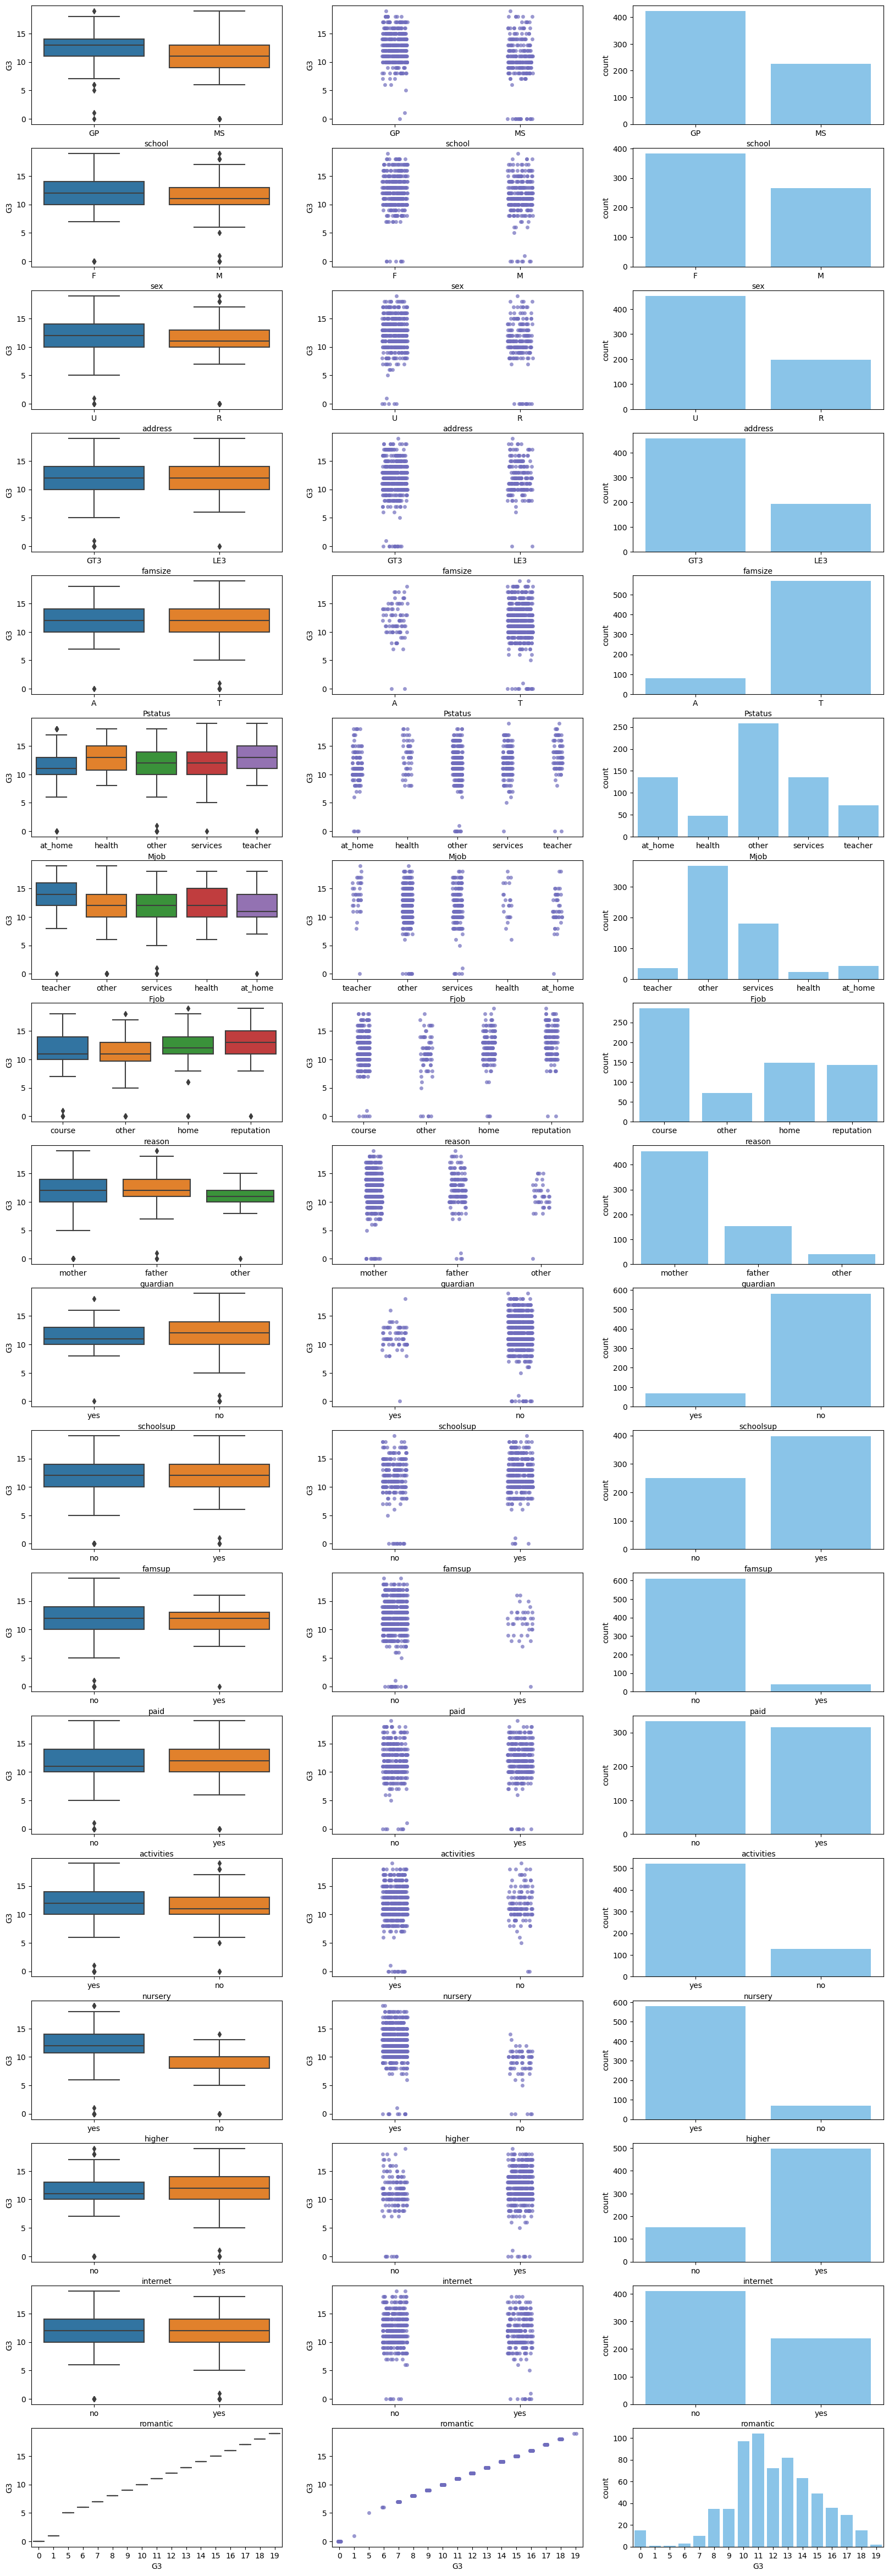

In [8]:
def plot_base_categorical_relation(df, figsize=(20, 60)):
    columns = df.columns.tolist()
    _, axs = plt.subplots(len(columns), 3, figsize=figsize)
    
    for idx, column in enumerate(columns):
        try:
            # To get knowledge about outliers & distribution
            sns.boxplot(x=df[column], y=df['G3'], ax=axs[idx][0])

            # To get its realtion with Average Grades
            sns.stripplot(
                x=column, y='G3', data=df,
                color='#706dbd', alpha=.7, jitter=.1,
                ax=axs[idx][1]
            )

            # To get count plot for `column` (considering NaN, so we can know 
            # how much of data is missing)
            plot_countplot(df, column, axs[idx][2])
        except ValueError:
            # ValueError: min() arg is an empty sequence
            # 
            # The above error happens while creating plot for some columns (maybe 
            # because it has NaN value)
            print(f'{column} cannot be plotted')
        
        
plot_base_categorical_relation(
    pd.concat(
        [df.select_dtypes(include=['object']), df[['G3']]],
        axis='columns'
    )
)

   age  Medu  Fedu  traveltime  studytime  failures  famrel  freetime  goout  \
0   18     4     4           2          2         0       4         3      4   
1   17     1     1           1          2         0       5         3      3   
2   15     1     1           1          2         0       4         3      2   
3   15     4     2           1          3         0       3         2      2   
4   16     3     3           1          2         0       4         3      2   

   Dalc  Walc  health  absences  G1  G2  G3  
0     1     1       3         4   0  11  11  
1     1     1       3         2   9  11  11  
2     2     3       3         6  12  13  12  
3     1     1       5         0  14  14  14  
4     1     2       5         0  11  13  13  


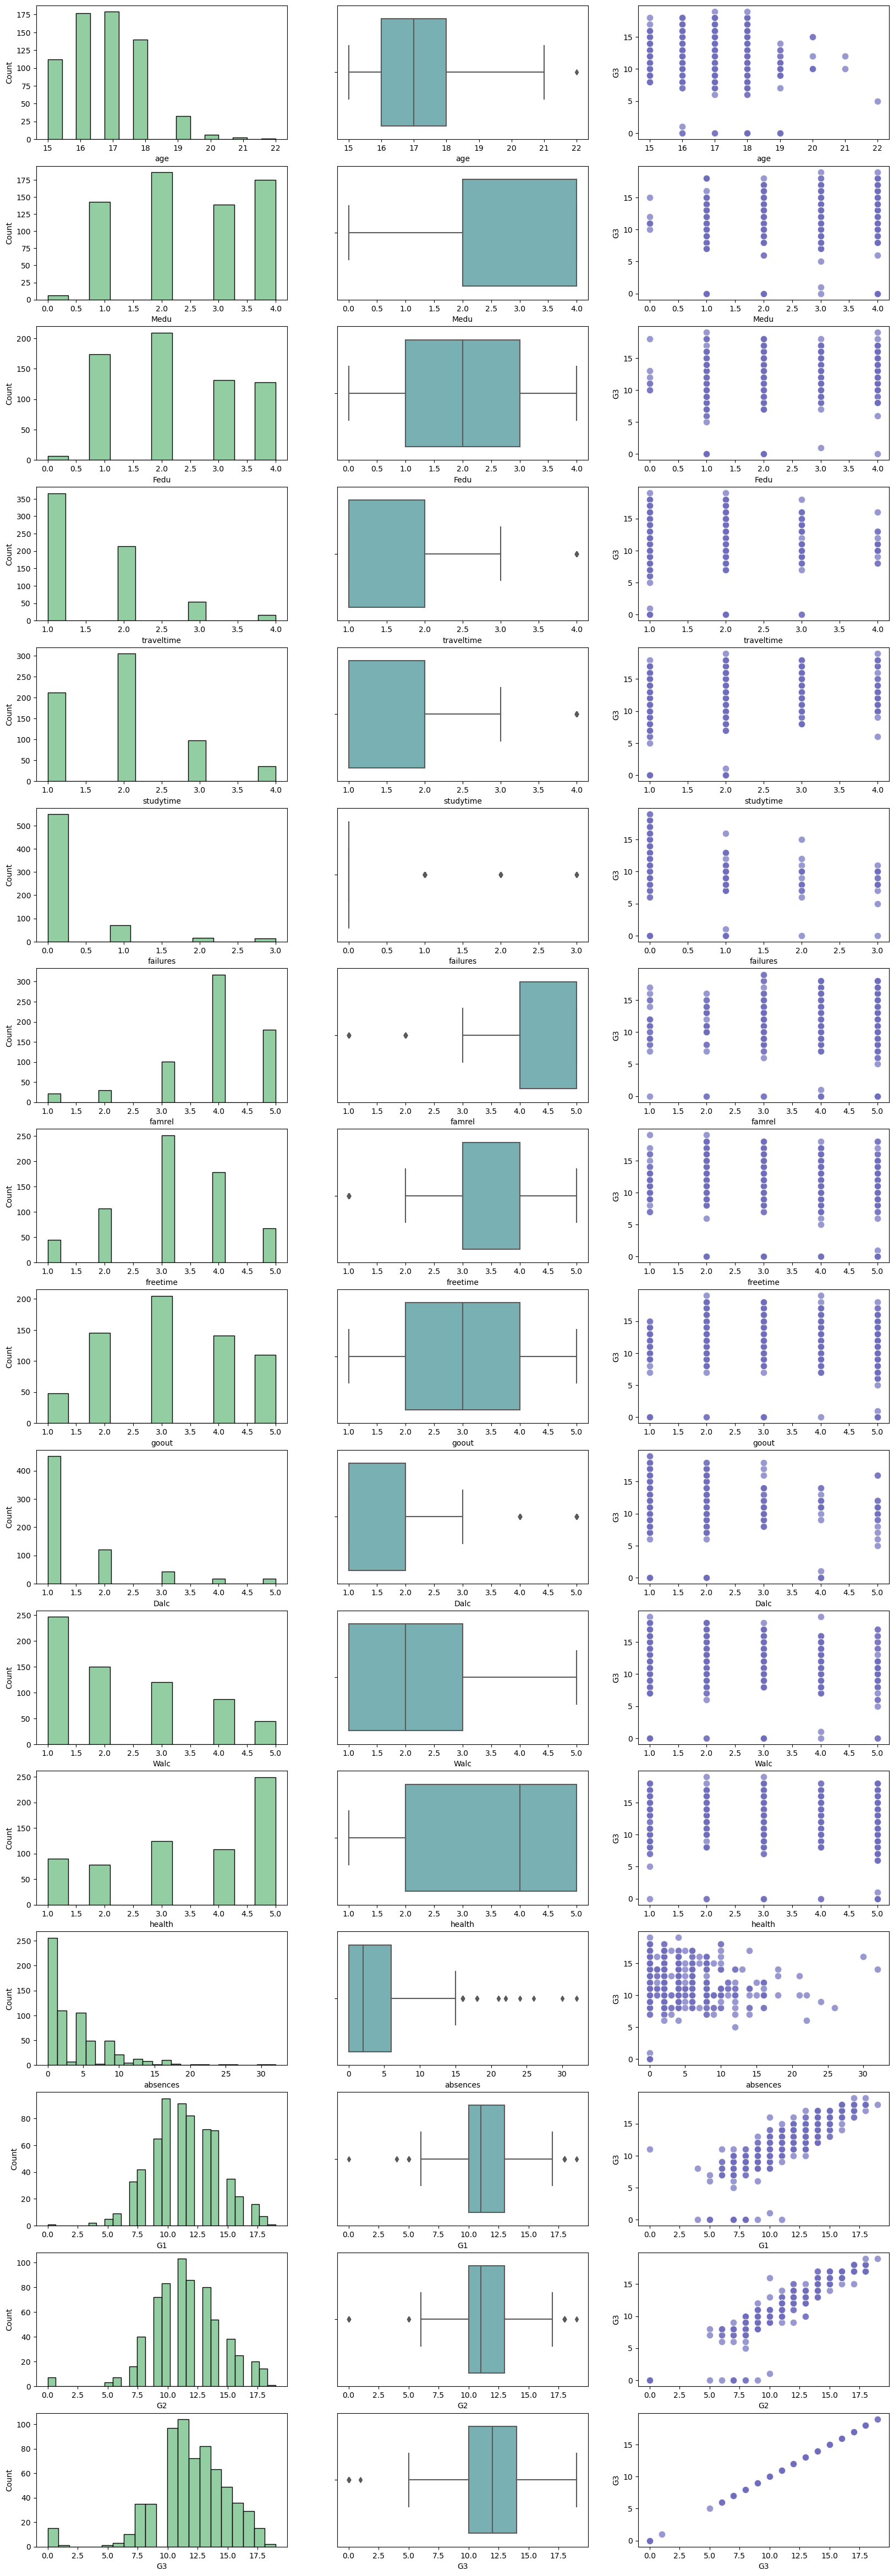

In [9]:
# Plotting base relations
def plot_base_relation(df, figsize=(20, 60)):
    columns = df.columns.tolist()
    _, axs = plt.subplots(len(columns), 3, figsize=figsize)

    for idx, column in enumerate(columns):
        # To get distribution of data
        sns.histplot(
            x=df[column],
            kde=False,
            color='#65b87b', alpha=.7,
            ax=axs[idx][0]
        )

        # To get knowledge about outliers
        sns.boxplot(
            x=df[column],
            color='#6fb9bd',
            ax=axs[idx][1]
        )

        # To get its relation with G3
        sns.scatterplot(
            x=column, y='G3', data=df,
            color='#706dbd', alpha=.7, s=80,
            ax=axs[idx][2]
        )
    plt.show()
new_df= df.select_dtypes(include=[int, float])
print(new_df.head())
plot_base_relation(df.select_dtypes(include=[int, float]))

### The above charts is a data exploration of the numeric features of the dataset

## Modelling Phase
## Creating a regression model that can predict student's final grades.

In [10]:
# KFold for cross validation
kf = KFold(n_splits=10, shuffle=True)

In [11]:
# Shuffling the dataset
numeric_df = df.select_dtypes(include='number')

numeric_df = numeric_df.sample(frac=1, random_state=5)
numeric_df.info

<bound method DataFrame.info of      age  Medu  Fedu  traveltime  studytime  failures  famrel  freetime  \
129   16     2     3           2          3         0       3         2   
140   17     3     4           3          2         0       5         4   
326   17     3     2           1          1         0       4         4   
328   18     1     1           2          2         0       5         4   
563   17     2     2           1          1         1       1         2   
..   ...   ...   ...         ...        ...       ...     ...       ...   
8     15     3     2           1          2         0       4         2   
73    16     3     1           1          1         0       5         3   
400   18     4     3           1          3         0       5         3   
118   17     1     3           3          2         1       5         2   
206   17     1     2           2          2         0       4         4   

     goout  Dalc  Walc  health  absences  G1  G2  G3  
129      3  

## Deriving Model without G1 and G2 as descriptive features

In [12]:
# Selecting features by analysing which features are collinear to `G3` and collinear 
# to the selected columns
features = ['failures', 'Medu', 'studytime', 'absences']
target = 'G3'

x_train, x_test, y_train, y_test = train_test_split(
    numeric_df[features], numeric_df[target], test_size=0.3, random_state=0
)

In [13]:
# Scaling the dataset

scaler = StandardScaler()

x_train = scaler.fit_transform(np.asanyarray(x_train))
y_train = np.asanyarray(y_train)

x_test = scaler.fit_transform(np.asanyarray(x_test))
y_test = np.asanyarray(y_test)

In [14]:
# Cross Validation
scoring = 'r2'
score = cross_val_score(linear_model.LinearRegression(), x_train, y_train, cv=4, scoring=scoring)
score.mean()

0.20176222478946013

In [15]:
# Plotting learning curve
_sizes = [i for i in range(1, 408, 10)]
train_sizes = np.array([_sizes])  # Relative sizes
scoring = 'neg_mean_squared_error'

lr = linear_model.LinearRegression()
train_sizes_abs, train_scores, cv_scores = learning_curve(
    lr, x_train, y_train, train_sizes=train_sizes, cv=10, scoring=scoring
)

In [16]:
train_scores_mean = []
for row in train_scores:
    _mean = row.mean()
    train_scores_mean.append(_mean)
    
cv_scores_mean = []
for row in cv_scores:
    _mean = row.mean()
    cv_scores_mean.append(_mean)    
    
train_scores_mean = -np.array(train_scores_mean)
cv_scores_mean = -np.array(cv_scores_mean)
    
print(train_scores_mean)
print()
print(cv_scores_mean)

[-0.          1.90092543  4.19772987  5.16691905  6.13660875  5.85307903
  6.32007424  6.01658974  6.88563598  8.36293138  8.03459731  7.61731779
  7.2608875   8.09370262  7.9470039   7.79396881  7.4056824   7.31537759
  7.52194386  7.42559824  7.51338875  7.4490348   7.7214919   7.62521387
  7.7613188   7.65985869  7.72078392  7.66910713  7.66891276  7.63573685
  7.59377202  7.61145712  7.64081868  7.56307691  7.45065845  7.39459957
  7.44957136  7.40112368  7.33706296  7.29943441  7.25204095]

[10.13608696 14.98814527  8.64256543  8.11640994  7.90384307  8.08497624
  8.11557433  8.15788654  8.06373749  7.85649839  7.82548938  7.86259118
  7.88236168  7.95759006  7.91752937  7.90107995  7.81716498  7.80840621
  7.88927568  7.81106421  7.80381681  7.80106985  7.83696882  7.82378328
  7.87957583  7.83221345  7.83461353  7.82217465  7.83457092  7.8214063
  7.81749455  7.81408373  7.75234768  7.75311402  7.74907051  7.73992864
  7.74160645  7.75285404  7.75325571  7.75056716  7.75954502]


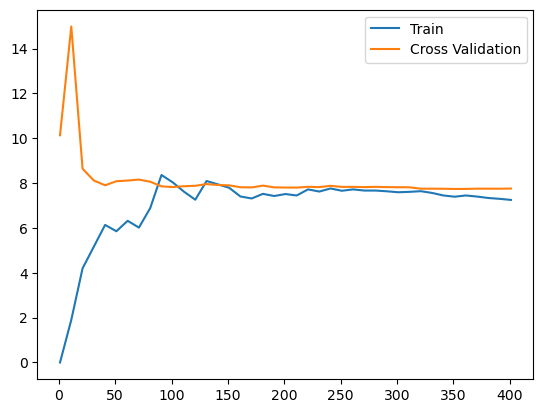

In [17]:
plt.plot(train_sizes_abs, train_scores_mean, label='Train')
plt.plot(train_sizes_abs, cv_scores_mean, label='Cross Validation')

plt.legend()

In [18]:
# Fitting the model
model = lr.fit(x_train, y_train)

In [19]:
# Optimal parameter
coefficients = model.coef_
intercept = model.intercept_

print("Coefficients: ", coefficients)
print("Intercept: ", model.intercept_)

Coefficients:  [-0.98514142  0.61708769  0.5556892  -0.27666384]
Intercept:  11.90308370044053


## Evaluation

In [20]:
y_test_pred = model.predict(x_test)


In [21]:
# To see how our model performs on data that model has NOT seen

rms_error = mean_squared_error(y_test, y_test_pred, squared=False)
r2_score_value = r2_score(y_test, y_test_pred)

print(f"Root mean squared error: {rms_error}")
print(f"R2-score: {r2_score_value}")

Root mean squared error: 3.0929425085641293
R2-score: 0.19646229464633025


## Creating a pipeline

In [22]:
scaling = ('scale', StandardScaler())
model = ('model', linear_model.LinearRegression())

# Steps in the pipeline
steps = [scaling, model]

pipe = Pipeline(steps=steps)

# Fiitting the model
model = pipe.fit(x_train, y_train)

# Out-Of-Sample Forecast
y_test_pred = model.predict(x_test)

# Evaluation
rms_error = mean_squared_error(y_test, y_test_pred, squared=False)
r2_score_value = r2_score(y_test, y_test_pred)

print(f"Root mean squared error: {rms_error}")
print(f"R2-score: {r2_score_value}")


Root mean squared error: 3.0929425085641293
R2-score: 0.19646229464633025


In [23]:
# Saving the model
dump(model, 'model.joblib')

['model.joblib']

## Visualizing our prediction against actual values.

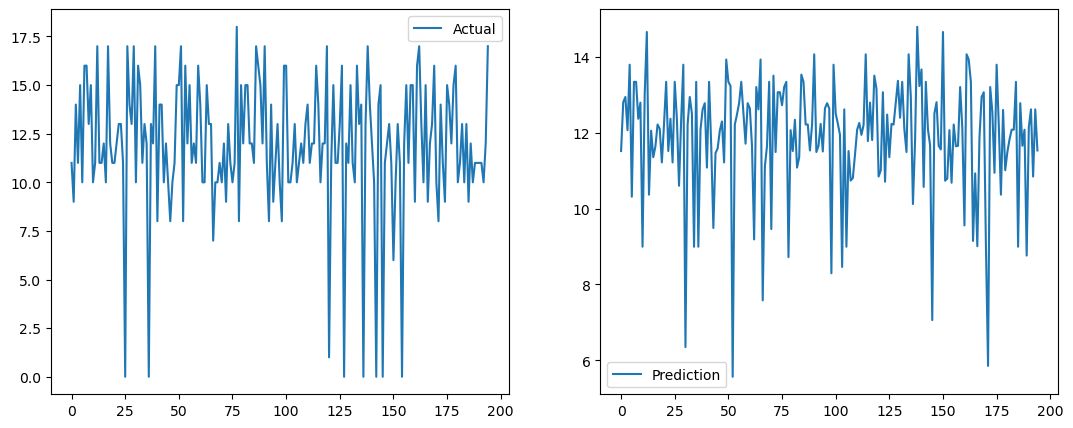

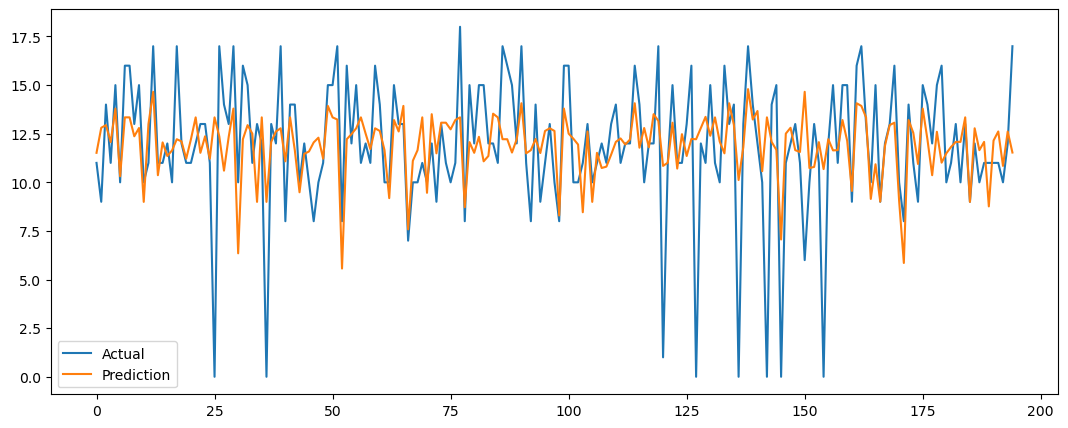

In [24]:
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))

ax1.plot(np.arange(len(y_test)), y_test, label='Actual')
ax2.plot(np.arange(len(y_test_pred)), y_test_pred, label='Prediction')

ax1.legend()
ax2.legend()

f, ax3 = plt.subplots(nrows=1, ncols=1, figsize=(13, 5))

ax3.plot(np.arange(len(y_test)), y_test, label='Actual')
ax3.plot(np.arange(len(y_test_pred)), y_test_pred, label='Prediction')

ax3.legend()

## Deriving Model with G1 and G2 as descriptive features

[-0.          0.85722403  0.76661954  1.02807968  1.03768506  0.93405601
  0.86557984  0.92842762  0.9420384   1.2715755   1.24168368  1.20436165
  1.20325017  1.16753359  1.13270458  1.1334949   1.10031456  1.14617076
  1.12198726  1.0857715   1.17877364  1.22730988  1.19957591  1.17343094
  1.21957096  1.18333312  1.16036325  1.14019168  1.12169604  1.11708226
  1.09453021  1.08085006  1.06094328  1.06365678  1.06457423  1.04828255
  1.03096495  1.02163349  1.01387079  1.00622203  0.99356359]

[10.13608696  6.16108389  1.81761879  1.47091175  1.29845788  1.30889521
  1.28631304  1.29720856  1.2229352   1.32650728  1.2815476   1.26011174
  1.24433781  1.22481606  1.22031937  1.21109255  1.19749642  1.20008547
  1.19636589  1.19340866  1.19387217  1.18852506  1.1902352   1.19067708
  1.19037599  1.19278178  1.18772502  1.1885078   1.18523597  1.18131736
  1.18116863  1.17741676  1.17756387  1.17660858  1.17921584  1.17947727
  1.17786759  1.17854777  1.18168915  1.18004979  1.17941178]

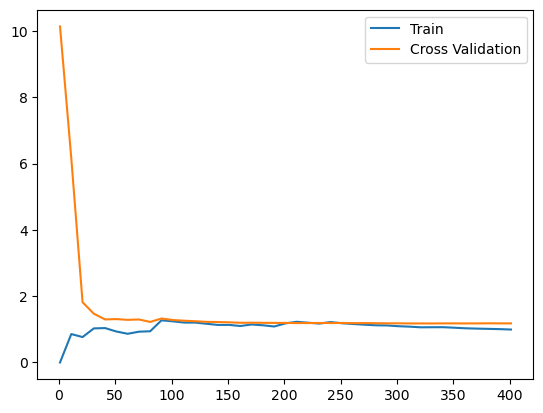

In [25]:
# Selecting features by analysing which features are collinear to `G3` and collinear 
# to the selected columns
features = ['failures', 'Medu', 'studytime', 'absences','G1','G2']
target = 'G3'

x_train, x_test, y_train, y_test = train_test_split(
    numeric_df[features], numeric_df[target], test_size=0.3, random_state=0
)

# Scaling the dataset

scaler = StandardScaler()

x_train = scaler.fit_transform(np.asanyarray(x_train))
y_train = np.asanyarray(y_train)

x_test = scaler.fit_transform(np.asanyarray(x_test))
y_test = np.asanyarray(y_test)

# Cross Validation
scoring = 'r2'
score = cross_val_score(linear_model.LinearRegression(), x_train, y_train, cv=4, scoring=scoring)
score.mean()

# Plotting learning curve
_sizes = [i for i in range(1, 408, 10)]
train_sizes = np.array([_sizes])  # Relative sizes
scoring = 'neg_mean_squared_error'

lr = linear_model.LinearRegression()
train_sizes_abs, train_scores, cv_scores = learning_curve(
    lr, x_train, y_train, train_sizes=train_sizes, cv=10, scoring=scoring
)


train_scores_mean = []
for row in train_scores:
    _mean = row.mean()
    train_scores_mean.append(_mean)
    
cv_scores_mean = []
for row in cv_scores:
    _mean = row.mean()
    cv_scores_mean.append(_mean)    
    
train_scores_mean = -np.array(train_scores_mean)
cv_scores_mean = -np.array(cv_scores_mean)
    
print(train_scores_mean)
print()
print(cv_scores_mean)

plt.plot(train_sizes_abs, train_scores_mean, label='Train')
plt.plot(train_sizes_abs, cv_scores_mean, label='Cross Validation')

plt.legend()

# Fitting the model
model = lr.fit(x_train, y_train)

# Optimal parameter
coefficients = model.coef_
intercept = model.intercept_

print("Coefficients: ", coefficients)
print("Intercept: ", model.intercept_)

## Evaluation

Root mean squared error: 1.5929264459871457
R2-score: 0.7868653742579629
Root mean squared error: 1.592926445987146
R2-score: 0.7868653742579629


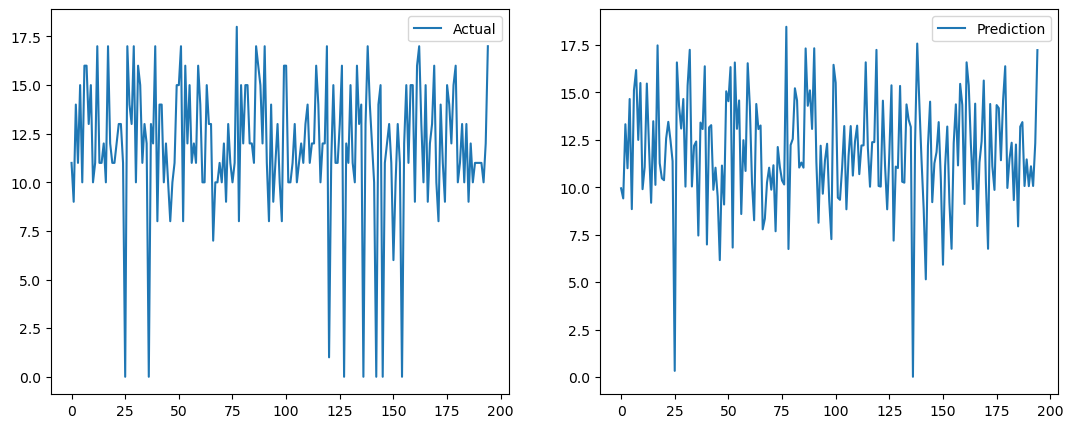

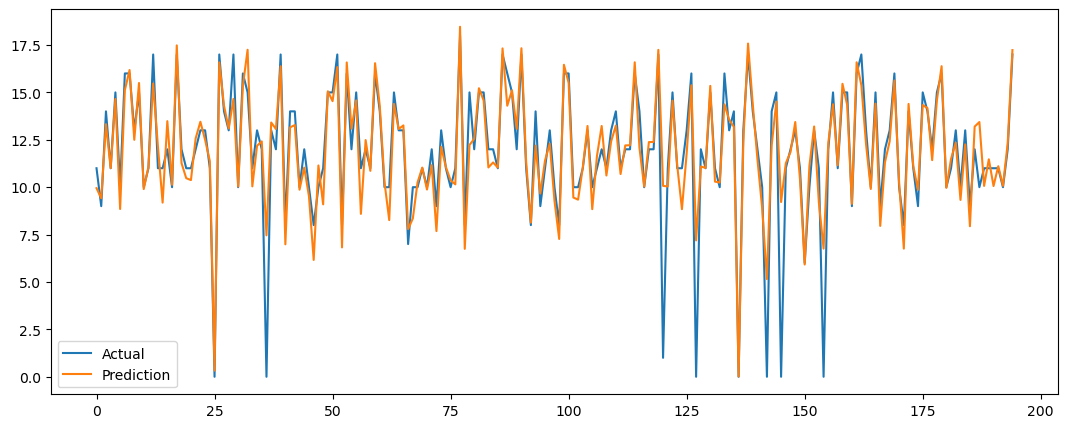

In [26]:
y_test_pred = model.predict(x_test)
# To see how our model performs on data that model has NOT seen

rms_error = mean_squared_error(y_test, y_test_pred, squared=False)
r2_score_value = r2_score(y_test, y_test_pred)

print(f"Root mean squared error: {rms_error}")
print(f"R2-score: {r2_score_value}")


scaling = ('scale', StandardScaler())
model = ('model', linear_model.LinearRegression())

# Steps in the pipeline
steps = [scaling, model]

pipe = Pipeline(steps=steps)

# Fiitting the model
model = pipe.fit(x_train, y_train)

# Out-Of-Sample Forecast
y_test_pred = model.predict(x_test)

# Evaluation
rms_error = mean_squared_error(y_test, y_test_pred, squared=False)
r2_score_value = r2_score(y_test, y_test_pred)

print(f"Root mean squared error: {rms_error}")
print(f"R2-score: {r2_score_value}")

f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))

ax1.plot(np.arange(len(y_test)), y_test, label='Actual')
ax2.plot(np.arange(len(y_test_pred)), y_test_pred, label='Prediction')

ax1.legend()
ax2.legend()

f, ax3 = plt.subplots(nrows=1, ncols=1, figsize=(13, 5))

ax3.plot(np.arange(len(y_test)), y_test, label='Actual')
ax3.plot(np.arange(len(y_test_pred)), y_test_pred, label='Prediction')

ax3.legend()